In [1]:
%matplotlib inline

from ROOT import TFile,vector
import ROOT
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from numpy import asarray

import seaborn as sns

Welcome to JupyROOT 6.12/06


/usr/local/lib/python2.7/dist-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.3 is currently installed but you installed root_numpy against numpy 1.14.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
def bless_mcinfo(row):
    try:
        idx = tuple((row['run'],row['subrun'],row['event']))
        if MCInfo[idx]['nuPDG'] in [12,-12]:
            return 0
        else:
            return 1
    except:
        return 0
    
def bless_scedr(row):
    scedr = float(-1)
    dx = row['Xreco'] - row['parentSCEX']
    dy = row['Yreco'] - row['parentSCEY']
    dz = row['Zreco'] - row['parentSCEZ']
    dr2 = dx*dx+dy*dy+dz*dz
    dr = np.sqrt(dr2)
    
    scedr = dr
    return scedr

def bless_ccqe_reweight(row):
    rw = float(1)
    if row['interactionType']==1001:
        rw = xsec_tune1_graph.Eval(row['energyInit']) / xsec_mcc9_graph.Eval(row['energyInit'])
    return rw

In [3]:
def distplot(nbins,myrange,_hists,data,data_weight,stxcoord,ymax):

    fig.patch.set_alpha(1)
    vals_mc = np.zeros(nbins)

    for i in xrange(0,len(_hists)):
        v1,binedges = np.histogram(_hists[i],nbins,range=myrange,weights=a_weights[i])
        vals_mc += v1

    vals_data,_ = np.histogram(var_data,nbins,range=myrange,weights=data_weight)

    bincenters = np.diff(binedges)/2 + binedges[:-1]     
    
    plt.ylim(0,ymax)
    plt.xlim(myrange)
    ax.set_xlabel(stxcoord,fontsize=20)
    ax.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax.set_title('MCC9 Data/MC',fontsize=30)

    plt.hist(_hists,nbins,range=myrange,weights=a_weights,color=a_colors,stacked=True,linewidth=2.5,label=a_labels,edgecolor='None')
    ax.errorbar(bincenters,vals_data,fmt='.',yerr=np.sqrt(vals_data/DATA_POT*POT_SCALE_FACTOR),color='black',capsize=5,label='bnb5e19')

    ax.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)
    
    print 'Events:',vals_data.sum()

In [4]:
NUMU_POT = 1.182344587853327e+21
NUMU_POT_BNB5E19RANGE = 5.534263853054876e+19

NUE_POT = 1.0830766933130594e+23
NUE_POT_BNB5E19RANGE = 2.110675254122294e+21

DATA_POT_UNCORRECTED = 3.541e+19
DATA_POT_CORRECTED = 4.365e+19
DATA_POT_EMPTY = 9.283e+15
DATA_POT = DATA_POT_CORRECTED + DATA_POT_EMPTY

EXT_POT_UNCORRECTED = 6361606.0 / 8862735.0 * 3.985e+19
#EXT_POT_CORRECTED = 12163846.0 / 19342610.0 * 8.119e+19
#EXT_POT_EMPTY = 6.988485e16
#EXT_POT =EXT_POT_CORRECTED + EXT_POT_EMPTY
EXT_POT = (12163846.0 + 15585) / float (10149967+2220) * DATA_POT
EXT_POT_BNB5E19RANGE  = (5124649 + 9298) / float (10149967+2220) * DATA_POT


POT_SCALE_FACTOR = DATA_POT

NUMU_SCALE = POT_SCALE_FACTOR / float(NUMU_POT)
NUE_SCALE = POT_SCALE_FACTOR / float(NUE_POT)
EXT_SCALE = POT_SCALE_FACTOR / float(EXT_POT)
DATA_SCALE = POT_SCALE_FACTOR / float(DATA_POT)

DATA_SCALE_UNCORRECTED = 1.0
EXT_SCALE_UNCORRECTED = DATA_POT_UNCORRECTED / EXT_POT_UNCORRECTED

print EXT_POT_UNCORRECTED
print EXT_POT_BNB5E19RANGE
print EXT_SCALE
print DATA_SCALE
print DATA_POT_CORRECTED

2.86040369141e+19
2.2078439353e+19
0.833551830131
1.0
4.365e+19


## Pickle for later

In [5]:
# Or, we can load from pickles if you, you know, want to.
# Pickle read for easy access later, eh?
tag = 'Oct31_fullrange'
df_data_goodruns_pmtprecut = pd.read_pickle('../data/pickles/data_goodruns_pmtprecut_%s.pkl'%tag)
df_numu_goodruns_pmtprecut = pd.read_pickle('../data/pickles/numu_goodruns_pmtprecut_%s.pkl'%tag)
df_nue_goodruns_pmtprecut = pd.read_pickle('../data/pickles/nue_goodruns_pmtprecut_%s.pkl'%tag)
df_ext_goodruns_pmtprecut = pd.read_pickle('../data/pickles/ext_goodruns_pmtprecut_%s.pkl'%tag)

## This is where the magic happens

In [6]:
df_numu_presel = df_numu_goodruns_pmtprecut.query('PassCuts == 1 and PassShowerReco == 1 and PassSecShr == 1')
df_nue_presel = df_nue_goodruns_pmtprecut.query('PassCuts == 1 and PassShowerReco == 1 and PassSecShr == 1')
df_ext_presel = df_ext_goodruns_pmtprecut.query('PassCuts == 1 and PassShowerReco == 1 and PassSecShr == 1')
df_data_presel = df_data_goodruns_pmtprecut.query('PassCuts == 1 and PassShowerReco == 1 and PassSecShr == 1')

Events: 2946.0


Text(0.7,0.7,'Fiducial, Two-Track,and \nContainment Cuts Applied')

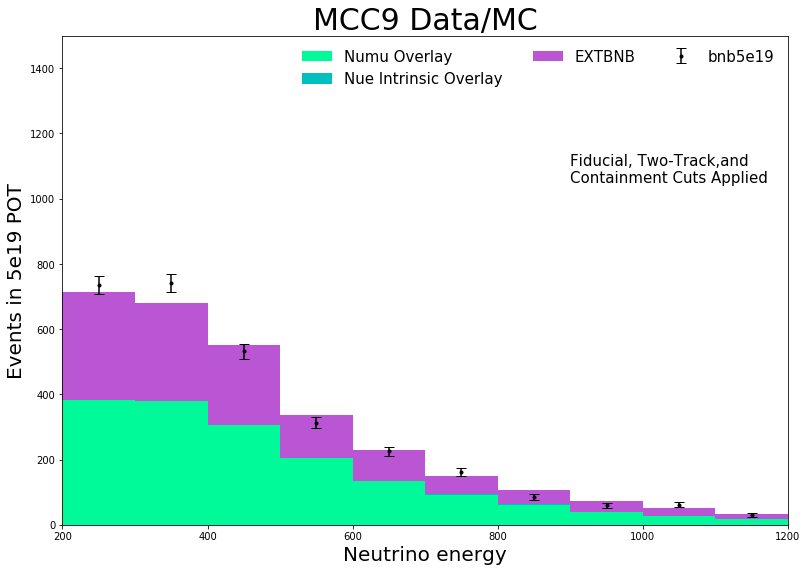

In [7]:
var_numu = df_numu_presel['Enu_1e1p'].values
var_nue = df_nue_presel['Enu_1e1p'].values
var_ext = df_ext_presel['Enu_1e1p'].values
var_data = df_data_presel['Enu_1e1p'].values

weights_numu_presel = df_numu_presel['geniereweight'].values*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight'].values*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE
a_weights = [weights_numu_presel,weights_nue_presel,weights_ext_presel]
#a_pot = [NUMU_POT,NUE_POT,EXT_POT]
a_labels = ['Numu Overlay','Nue Intrinsic Overlay','EXTBNB']
a_colors = ['mediumspringgreen','c','mediumorchid']

fig,ax = plt.subplots(figsize=(13,9))
distplot(10,(200,1200),[var_numu,var_nue,var_ext],var_data,weights_data_presel,'Neutrino energy',1.5e3)
ax.annotate('Fiducial, Two-Track,and \nContainment Cuts Applied',xy=(.7,.7), xycoords='axes fraction',fontsize=15)
#ax.annotate('6808 Events in 5e19',xy=(.7,.6), xycoords='axes fraction',fontsize=20)


In [14]:
# Split NUMUs into all manner of ittle pieces
df_offvtx_numu_presel = df_numu_presel.query('scedir_corrected > 5')

df_CCQE_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and interactionType==1001')
df_MEC_numu_presel = df_numu_presel.query('scedir_corrected <= 5 and ineractionMode==10')

pizero = '(interactionType==1090 or interactionType==1086 or interactionType==1090 or interactionType==1015 or interactionType==1013 or interactionType==1011 or interactionType==1008 or interactionType==1006 or interactionType==1004)'
piplus = '(interactionType==1085 or interactionType==1079 or interactionType==1032 or interactionType==1017 or interactionType==1014 or interactionType==1007 or interactionType==1005 or interactionType==1003)'
piminus = '(interactionType==1085 or interactionType==1079 or interactionType==1028 or interactionType==1021 or interactionType==1016 or interactionType==1012 or interactionType==1010 or interactionType==1009)'

df_pizero_numu_presel = df_numu_presel.query('scedir_corrected < 5 and '+pizero)
df_piplusminus_numu_presel = df_numu_presel.query('scedir_corrected < 5 and '+piplus+' or '+piminus)
df_other_numu_presel = df_numu_presel.query('scedir_corrected < 5 and '+'interactionType!=1001 and ineractionMode!=10 and not '+pizero+' and not '+piplus+' and not '+piminus)

In [34]:
df_signal = df_nue_presel.query('energyInit < 1 and scedir_corrected < 5')
df_extbkg = pd.concat([df_ext_presel,df_offvtx_numu_presel,df_nue_presel.query('scedir_corrected > 10')])
df_numubkg = pd.concat([df_piplusminus_numu_presel,df_other_numu_presel,df_CCQE_numu_presel,df_MEC_numu_presel,df_pizero_numu_presel])

weights_offvtxnumu_presel = np.ones(len(df_offvtx_numu_presel))*NUMU_SCALE
weights_CCQEnumu_presel = df_CCQE_numu_presel['geniereweight']*NUMU_SCALE
weights_MECnumu_presel = np.ones(len(df_MEC_numu_presel))*NUMU_SCALE
weights_PIZEROnumu_presel = np.ones(len(df_pizero_numu_presel))*NUMU_SCALE
weights_PIPLUSMINUSnumu_presel = np.ones(len(df_piplusminus_numu_presel))*NUMU_SCALE
weights_OTHERnumu_presel = np.ones(len(df_other_numu_presel))*NUMU_SCALE
weights_nue_presel = df_nue_presel['geniereweight']*NUE_SCALE
weights_ext_presel = np.ones(len(df_ext_presel))*EXT_SCALE
weights_data_presel = np.ones(len(df_data_presel))*DATA_SCALE

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [35]:
a_weights = [weights_offvtxnumu_presel,weights_CCQEnumu_presel,weights_MECnumu_presel,weights_PIZEROnumu_presel,weights_PIPLUSMINUSnumu_presel,weights_OTHERnumu_presel,weights_nue_presel,weights_ext_presel]
a_labels = ['Off Vertex',r'$\nu_\mu$ CCQE',r'$\nu_\mu$ MEC',r'$\nu_\mu$ Res $\pi^0$',r'$\nu_\mu$ Res $\pi^{+/-}$',r'$\nu_\mu$ Other',r'$\nu_e$ Intrinsic Overlay','EXTBNB']
a_colors = ['gray','blue','cyan','darkgreen','greenyellow','gold','c','mediumorchid']

In [36]:
list(df_extbkg)

['AlphaTB_1e1p',
 'AlphaTB_1m1p',
 'AlphaT_1e1p',
 'AlphaT_1m1p',
 'AnyReco',
 'BDTprob',
 'BjXB_1e1p',
 'BjXB_1m1p',
 'BjX_1e1p',
 'BjX_1m1p',
 'BjYB_1e1p',
 'BjYB_1m1p',
 'BjY_1e1p',
 'BjY_1m1p',
 'CCQEEnergyShift_1e1p',
 'CCQEEnergyShift_1m1p',
 'ChargeNearTrunk',
 'EifMu_v',
 'EifP_v',
 'Electron_Edep',
 'Electron_EdepB_1e1p',
 'Electron_PhiRecoB_1e1p',
 'Electron_ThetaRecoB_e1ep',
 'Enu_1e1p',
 'Enu_1m1p',
 'Eta',
 'Good3DReco',
 'InFiducial',
 'Lepton_EdgeDist',
 'Lepton_ID',
 'Lepton_PhiReco',
 'Lepton_ThetaReco',
 'Lepton_TrackLength',
 'Lepton_dQdx',
 'LongTrackLen',
 'MaxShrFrac',
 'MinShrFrac',
 'Muon_Edep',
 'Muon_EdepB_1m1p',
 'Muon_PhiRecoB_1m1p',
 'Muon_ThetaRecoB_1m1p',
 'N5cmTracks',
 'NTracks',
 'OpenAng',
 'OpenAngB_1e1p',
 'OpenAngB_1m1p',
 'PIDe',
 'PIDg',
 'PIDmu',
 'PIDp',
 'PIDsh',
 'PTB_1e1p',
 'PTB_1m1p',
 'PTRat_1e1p',
 'PTRat_1m1p',
 'PT_1e1p',
 'PT_1m1p',
 'PassCuts',
 'PassSecShr',
 'PassShowerReco',
 'PhiTB_1e1p',
 'PhiTB_1m1p',
 'PhiT_1e1p',
 'PhiT_1m1p'

Events: 3516.0


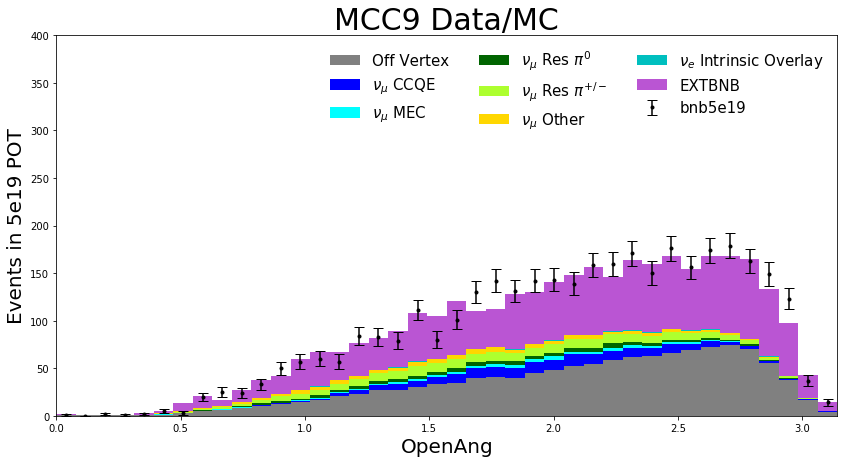

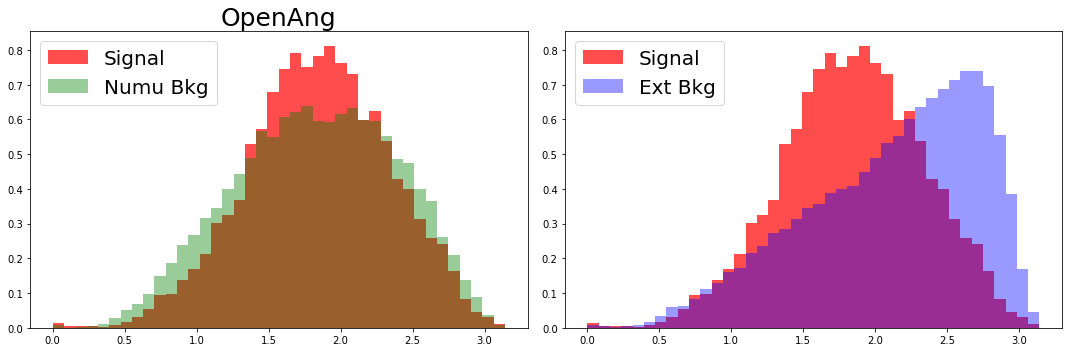

In [37]:
testvar = 'OpenAng'
myrange = (0,np.pi)
nbins = 40

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(14,7))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,.4e3)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
_ = ax[0].hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax[0].hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
ax[0].set_title(testvar,fontsize=25)
ax[0].legend(fontsize=20)
_ = ax[1].hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax[1].hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
ax[1].legend(fontsize=20)
fig.tight_layout()

Events: 2773.0


NameError: name 'var_pi0bkg' is not defined

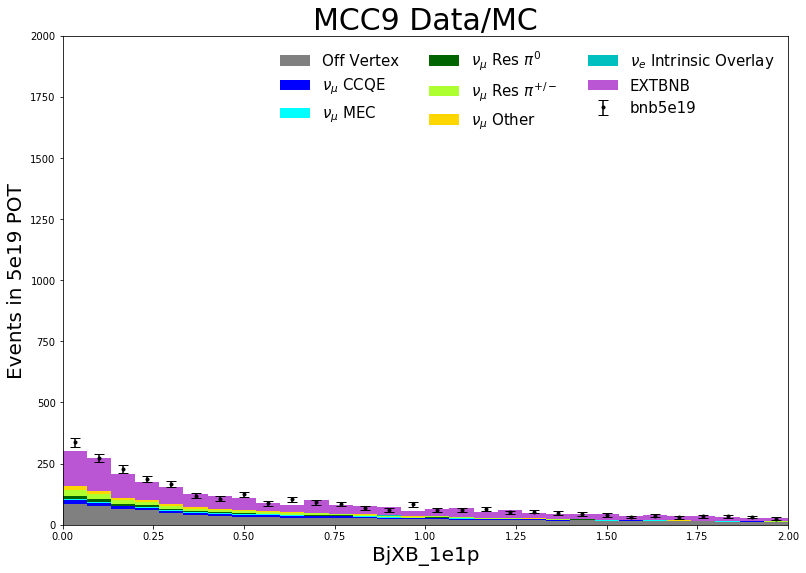

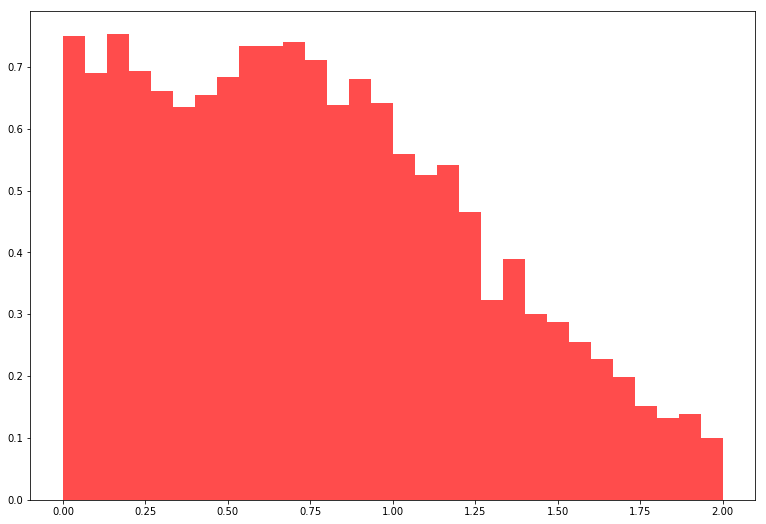

In [38]:
testvar = 'BjXB_1e1p'

myrange = (0,2)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
#var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


In [ ]:
testvar = 'Enu_1e1p'
myrange = (200,1000)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


In [ ]:
testvar = 'LongTrackLen'
myrange = (5,600)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


In [ ]:
testvar = 'ShortTrackLen'
myrange = (5,100)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3516.0


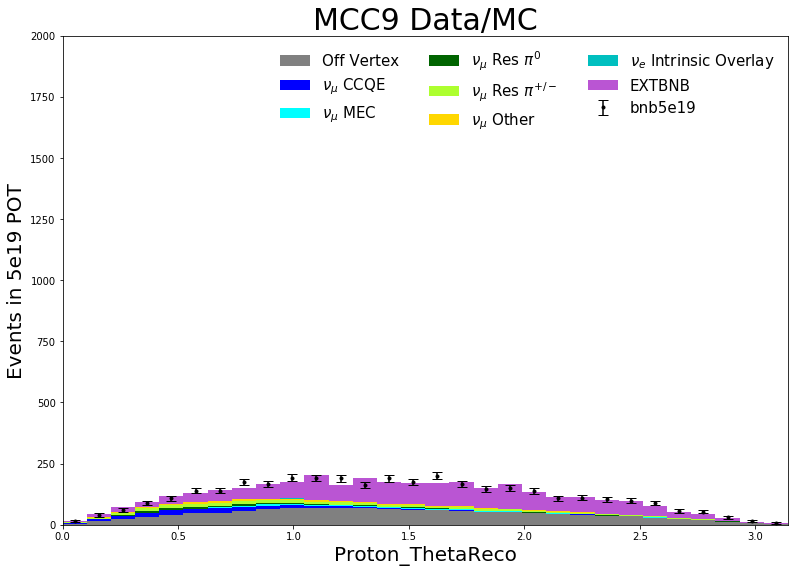

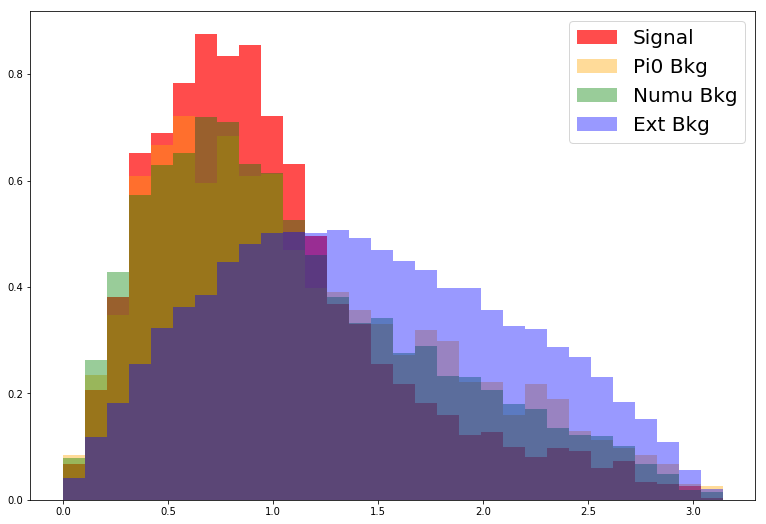

In [87]:
testvar = 'Proton_ThetaReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3516.0


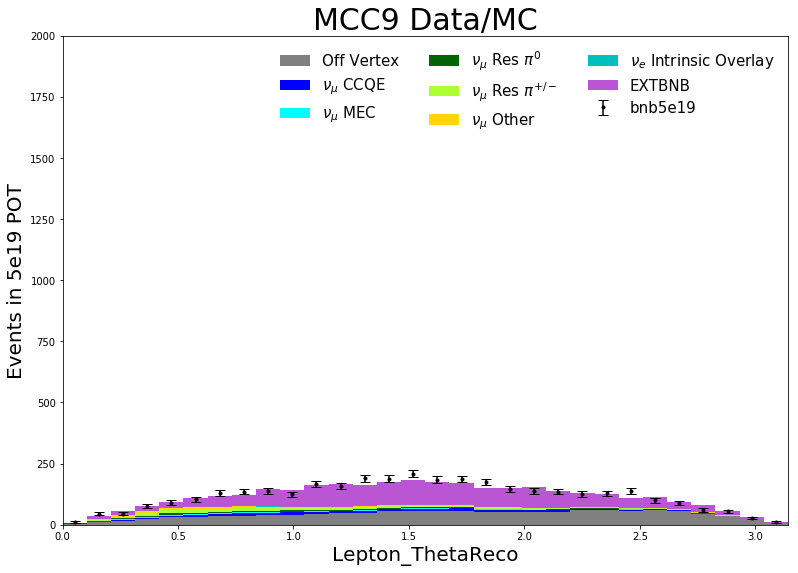

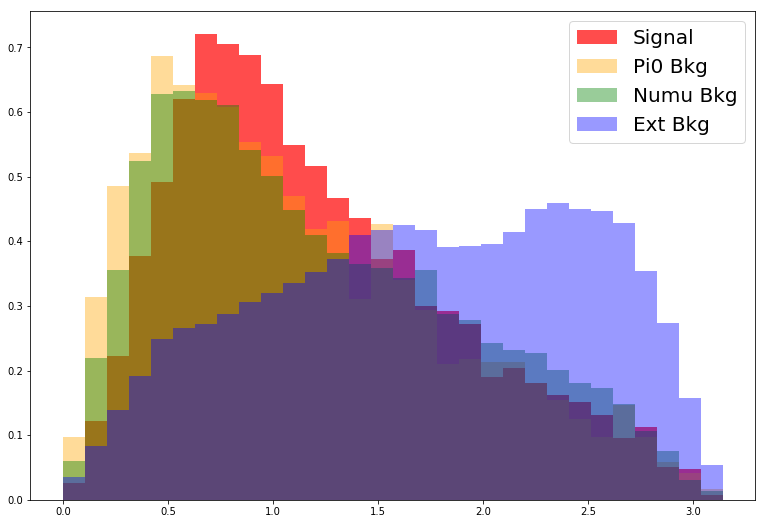

In [88]:
testvar = 'Lepton_ThetaReco'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3516.0


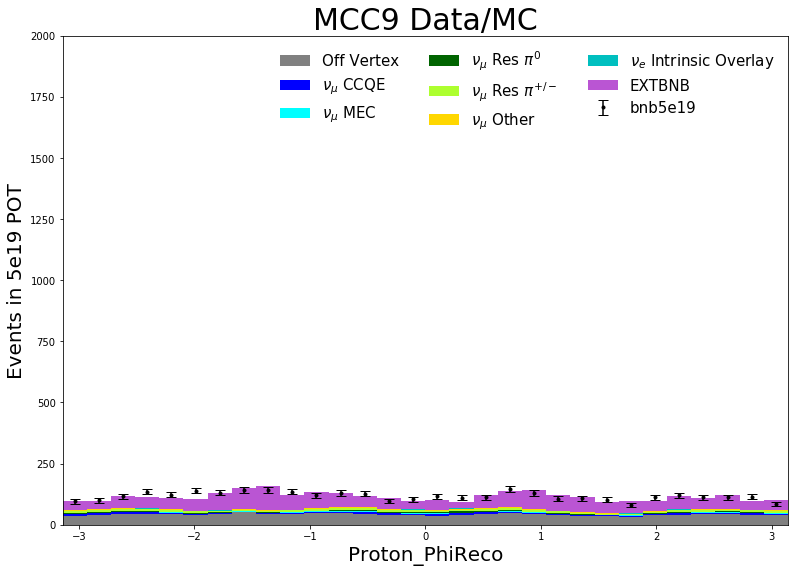

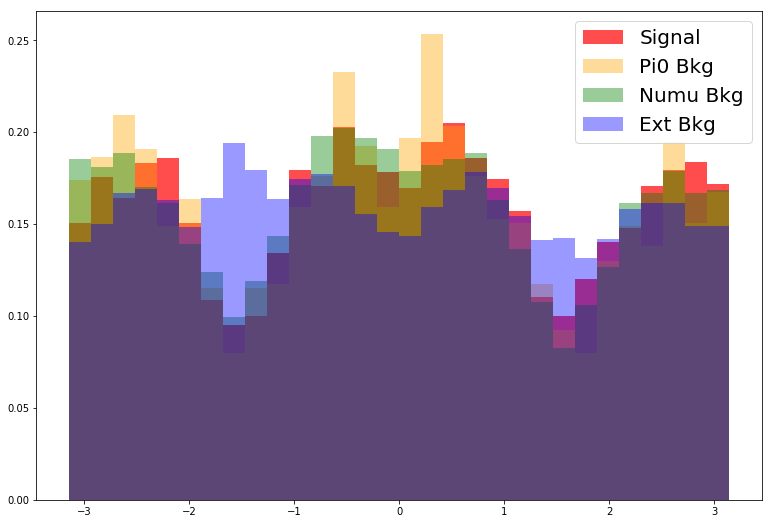

In [89]:
testvar = 'Proton_PhiReco'
myrange = (-np.pi,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3516.0


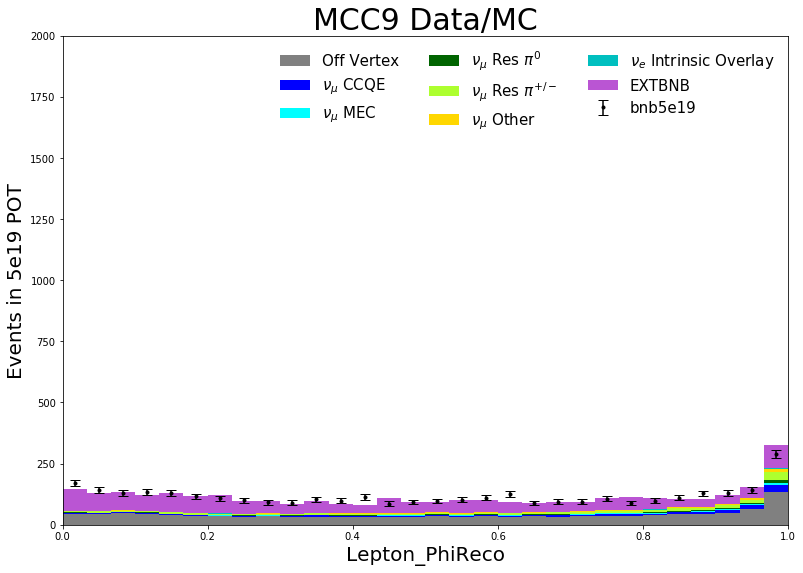

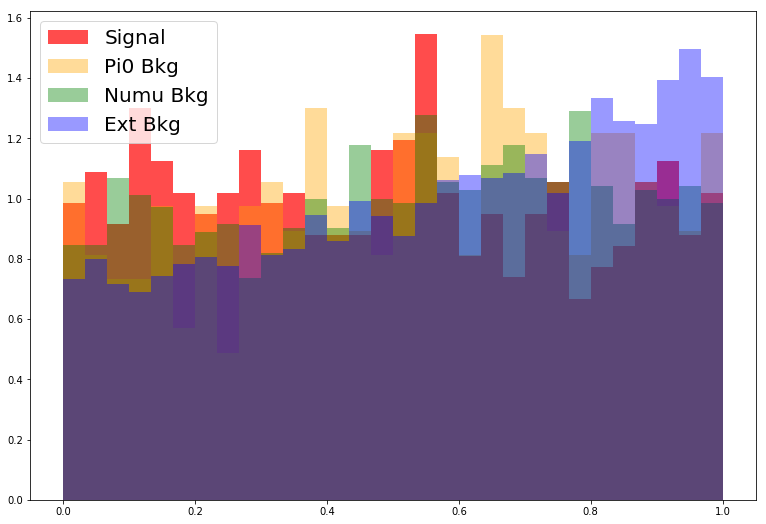

In [90]:
testvar = 'Lepton_PhiReco'
myrange = (0,1)
nbins = 30

var_offvtx = np.abs(np.cos(df_offvtx_numu_presel[testvar].values))
var_ccqe = np.abs(np.cos(df_CCQE_numu_presel[testvar].values ))
var_mec = np.abs(np.cos(df_MEC_numu_presel[testvar].values))
var_pizero = np.abs(np.cos(df_pizero_numu_presel[testvar].values))
var_piplusminus = np.abs(np.cos(df_piplusminus_numu_presel[testvar].values))
var_other = np.abs(np.cos(df_other_numu_presel[testvar].values))
var_nue = np.abs(np.cos(df_nue_presel[testvar].values))
var_ext = np.abs(np.cos(df_ext_presel[testvar].values))
var_data = np.abs(np.cos(df_data_presel[testvar].values))

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 1280.0


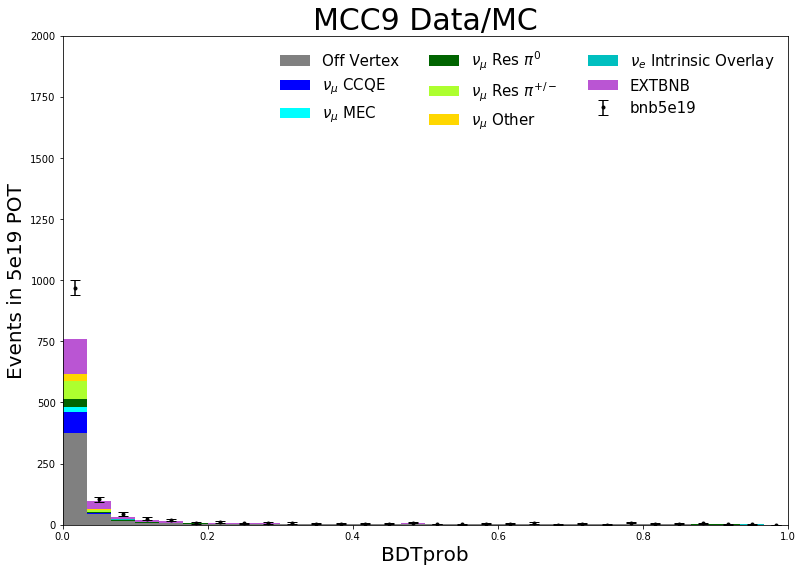

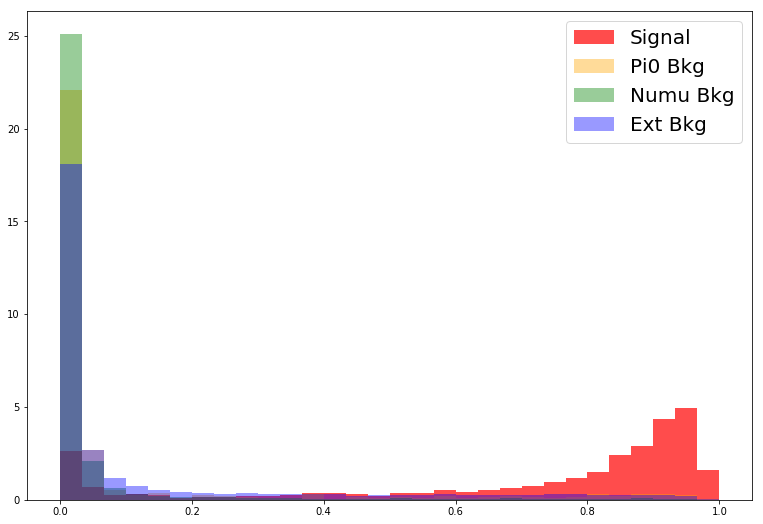

In [75]:
testvar = 'BDTprob'
myrange = (0,1)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 1855.0


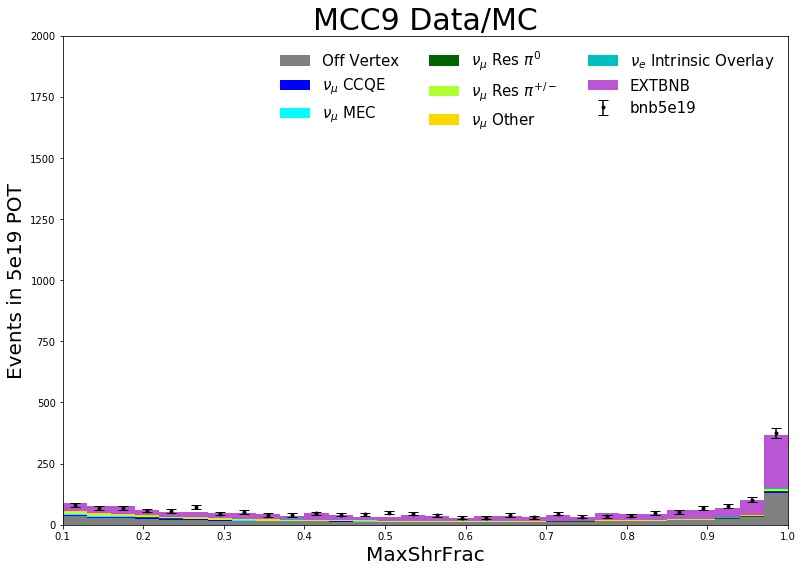

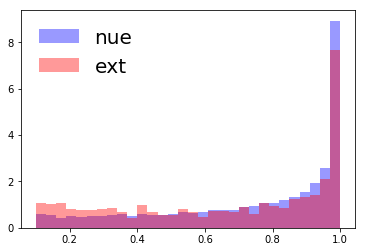

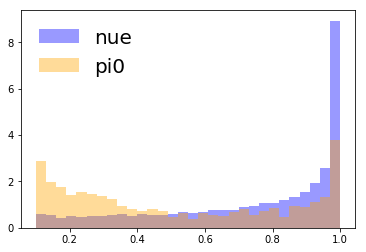

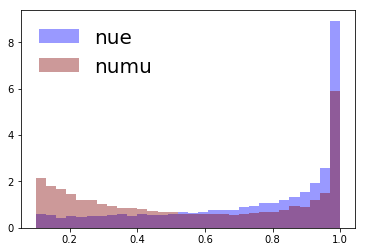

In [31]:
testvar = 'MaxShrFrac'
myrange = (0.1,1)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_numu_other = var_offvtx.tolist() + var_ccqe.tolist()  + var_mec.tolist() + var_piplusminus.tolist() + var_other.tolist()

fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_pizero,nbins,range=myrange,color='orange',alpha=.4,label='pi0',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_numu_other,nbins,range=myrange,color='maroon',alpha=.4,label='numu',density=1)
_=plt.legend(frameon=False,fontsize=20)



Events: 651.0


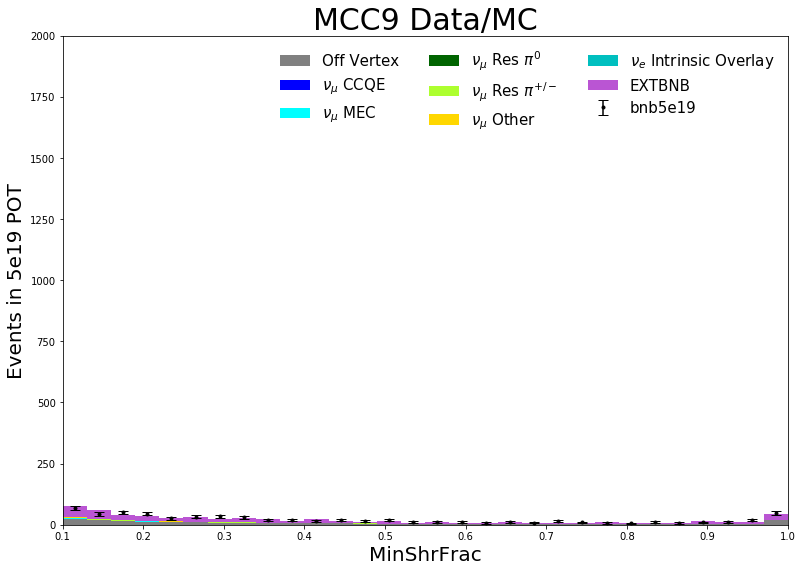

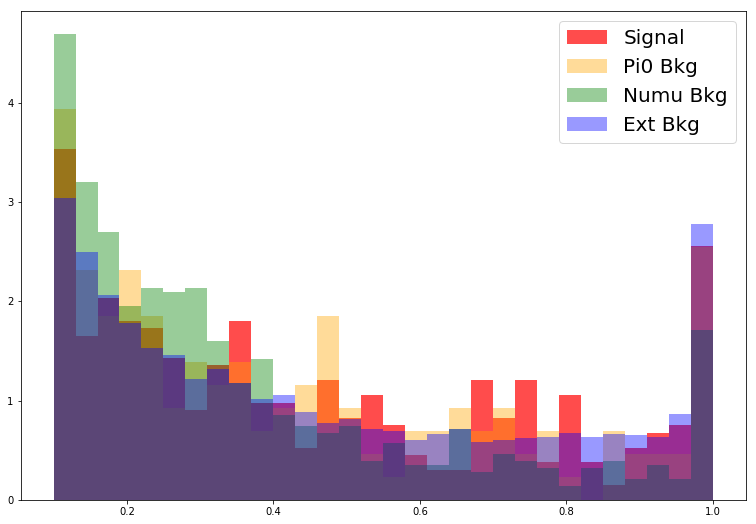

In [50]:
testvar = 'MinShrFrac'
myrange = (.1,1)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3276.0


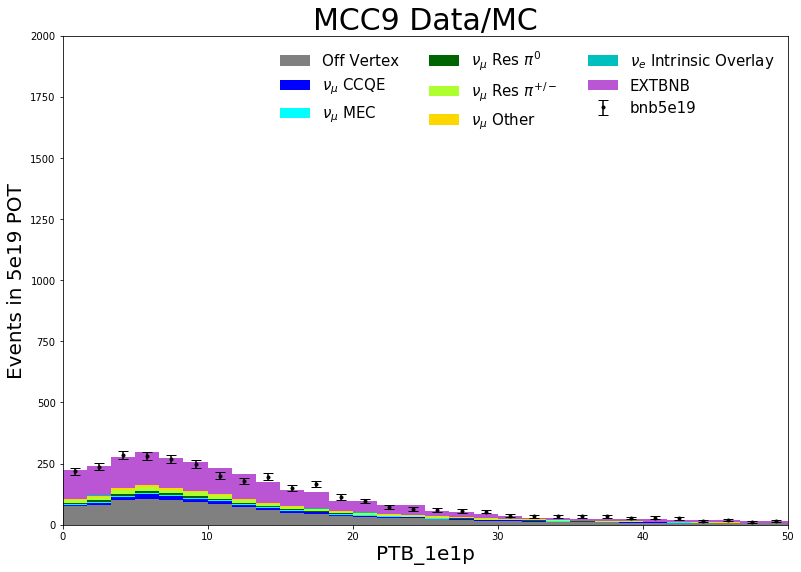

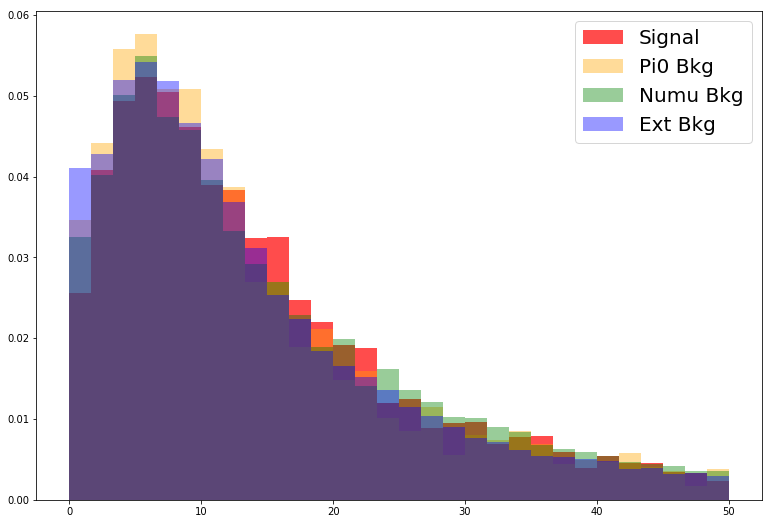

In [54]:
testvar = 'PTB_1e1p'
myrange = (0,50)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_signal = df_signal[testvar].values
var_pi0bkg = df_pi0bkg[testvar].values
var_numubkg = df_numubkg[testvar].values
var_extbkg = df_extbkg[testvar].values


fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)


fig,ax = plt.subplots(figsize=(13,9))
_ = ax.hist(var_signal,nbins,range=myrange,color='red',alpha=.7,label='Signal',density=1)
_ = ax.hist(var_pi0bkg,nbins,range=myrange,color='orange',alpha=.4,label='Pi0 Bkg',density=1)
_ = ax.hist(var_numubkg,nbins,range=myrange,color='green',alpha=.4,label='Numu Bkg',density=1)
_ = ax.hist(var_extbkg,nbins,range=myrange,color='blue',alpha=.4,label='Ext Bkg',density=1)
plt.legend(fontsize=20)


Events: 3516.0


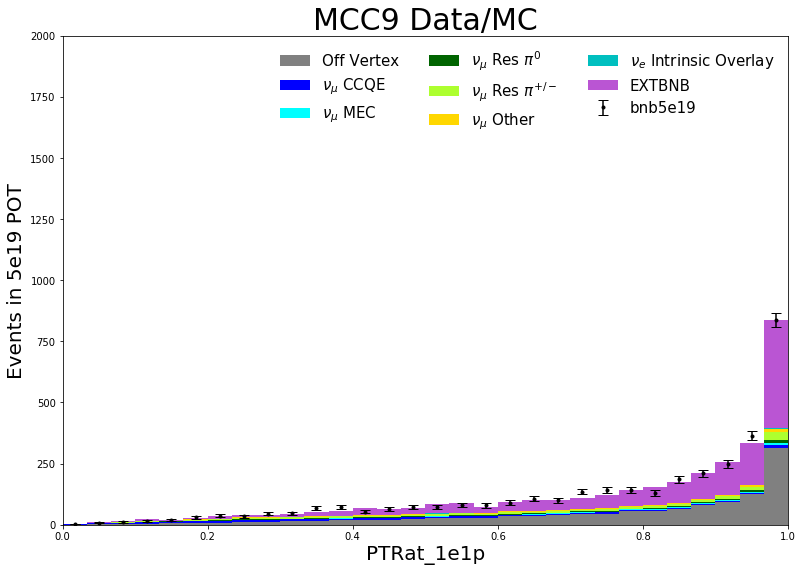

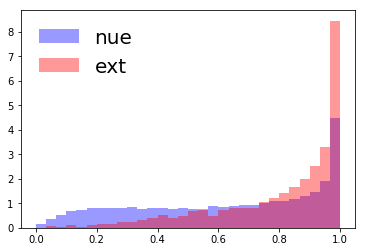

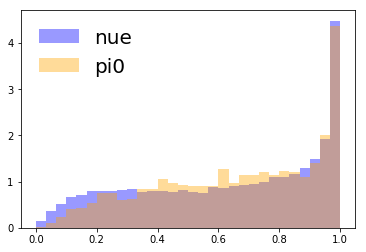

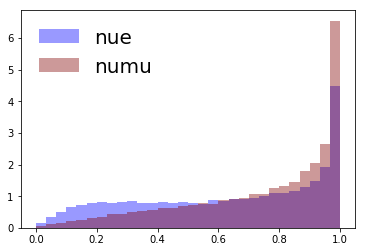

In [62]:
testvar = 'PTRat_1e1p'
myrange = (0,1)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_numu_other = var_offvtx.tolist() + var_ccqe.tolist()  + var_mec.tolist() + var_piplusminus.tolist() + var_other.tolist()

fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_pizero,nbins,range=myrange,color='orange',alpha=.4,label='pi0',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_numu_other,nbins,range=myrange,color='maroon',alpha=.4,label='numu',density=1)
_=plt.legend(frameon=False,fontsize=20)


Events: 3516.0


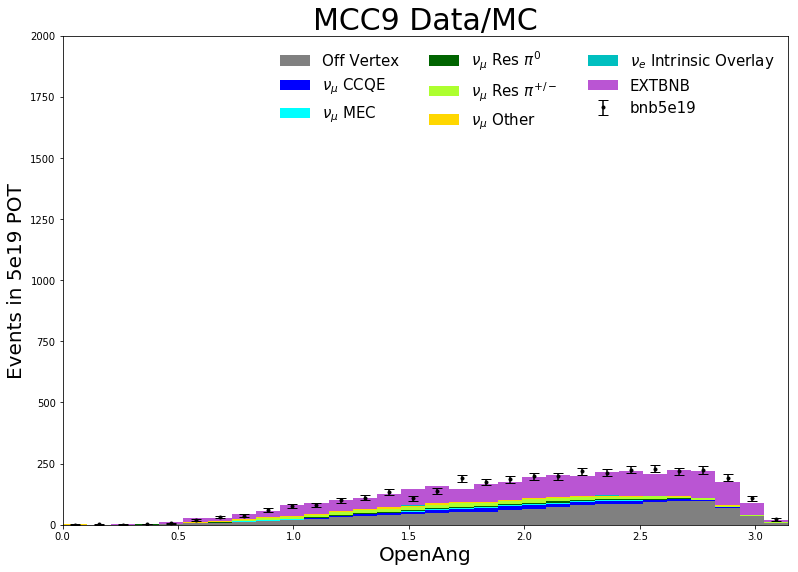

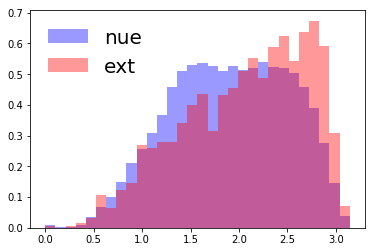

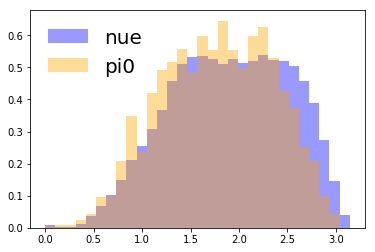

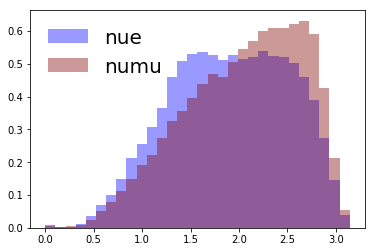

In [63]:
testvar = 'OpenAng'
myrange = (0,np.pi)
nbins = 30

var_offvtx = df_offvtx_numu_presel[testvar].values
var_ccqe = df_CCQE_numu_presel[testvar].values 
var_mec = df_MEC_numu_presel[testvar].values
var_pizero = df_pizero_numu_presel[testvar].values
var_piplusminus = df_piplusminus_numu_presel[testvar].values
var_other = df_other_numu_presel[testvar].values
var_nue = df_nue_presel[testvar].values
var_ext = df_ext_presel[testvar].values
var_data = df_data_presel[testvar].values

var_numu_other = var_offvtx.tolist() + var_ccqe.tolist()  + var_mec.tolist() + var_piplusminus.tolist() + var_other.tolist()

fig,ax = plt.subplots(figsize=(13,9))
distplot(nbins,myrange,[var_offvtx,var_ccqe,var_mec,var_pizero,var_piplusminus,var_other,var_nue,var_ext],var_data,weights_data_presel,testvar,2e3)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_ext,nbins,range=myrange,color='red',alpha=.4,label='ext',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_pizero,nbins,range=myrange,color='orange',alpha=.4,label='pi0',density=1)
_=plt.legend(frameon=False,fontsize=20)

fig,ax = plt.subplots(figsize=(6,4))
_ = ax.hist(var_nue,nbins,range=myrange,color='blue',alpha=.4,label='nue',density=1)
_ = ax.hist(var_numu_other,nbins,range=myrange,color='maroon',alpha=.4,label='numu',density=1)
_=plt.legend(frameon=False,fontsize=20)


In [13]:
# Cosmic vs nue
jarretvars = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','BDTprob','maxshrFrac','minshrFrac','PIDmu','PIDp','PIDsh']
selecvars_v1 = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','maxshrFrac','minshrFrac','sph_1e1p','pzEnu_1e1p','bjY_1e1p','openAng','Proton_Edep','Electron_Edep','Muon_Edep']

jarretvars_v2 = ['Proton_ThetaReco','Lepton_ThetaReco','Eta','BjXB_1e1p','BjYB_1e1p','OpenAng','PzEnu_1e1p','PT_1e1p','PTRat_1e1p','Sph_1e1p','Enu_1e1p','MaxShrFrac','MinShrFrac','ChargeNearTrunk','CCQEEnergyShift_1e1p']


myvars = jarretvars_v2

X = df_signal[myvars].values.tolist()
Y_cos = df_extbkg[myvars].values.tolist()


#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_cos))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_cos), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
cosmicBDT = XGBClassifier(silent=True, 
                        scale_pos_weight=1,
                        learning_rate=0.01,  
                        colsample_bytree = 1.0,
                        subsample = 0.9,
                        objective='binary:logistic', 
                        n_estimators=5000, 
                        max_depth=15, 
                        gamma=1,
                        eval_set=eval_set,
                        eval_metric="auc",
                        early_stopping_rounds = 30)
cosmicBDT.fit(x_train, y_train)

y_checkV = cosmicBDT.predict(x_test) #
y_checkT = cosmicBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('cosmicBDT Importance')
plt.bar(range(len(cosmicBDT.feature_importances_)), cosmicBDT.feature_importances_)
plt.xticks(range(len(cosmicBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

KeyboardInterrupt: 

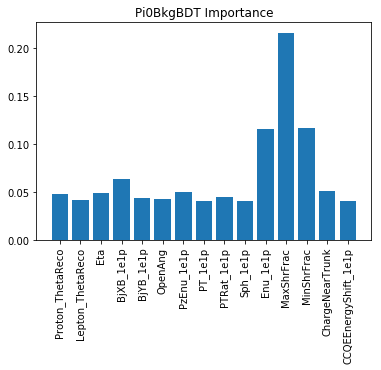

In [36]:
#pi0 vs nue
jarretvars = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','BDTprob','maxshrFrac','minshrFrac','PIDmu','PIDp','PIDsh']
selecvars_v1 = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','maxshrFrac','minshrFrac','sph_1e1p','pzEnu_1e1p','bjY_1e1p','openAng','Proton_Edep','Electron_Edep','Muon_Edep']

jarretvars_v2 = ['Proton_ThetaReco','Lepton_ThetaReco','Eta','BjXB_1e1p','BjYB_1e1p','OpenAng','PzEnu_1e1p','PT_1e1p','PTRat_1e1p','Sph_1e1p','Enu_1e1p','MaxShrFrac','MinShrFrac','ChargeNearTrunk','CCQEEnergyShift_1e1p']


myvars = jarretvars_v2

X = df_signal[myvars].values.tolist()
Y_pi0 = df_pi0bkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_pi0))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_pi0), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
pi0BDT = XGBClassifier(silent=True, 
                        scale_pos_weight=1,
                        learning_rate=0.01,  
                        colsample_bytree = 1.0,
                        subsample = 0.9,
                        objective='binary:logistic', 
                        n_estimators=5000, 
                        max_depth=15, 
                        gamma=1,
                        eval_set=eval_set,
                        eval_metric="auc",
                        early_stopping_rounds = 30)
pi0BDT.fit(x_train, y_train)

y_checkV = pi0BDT.predict(x_test) #
y_checkT = pi0BDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('Pi0BkgBDT Importance')
plt.bar(range(len(pi0BDT.feature_importances_)), pi0BDT.feature_importances_)
plt.xticks(range(len(pi0BDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

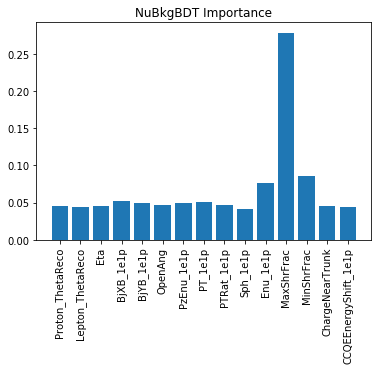

In [38]:
#numu vs nue
jarretvars = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','BDTprob','maxshrFrac','minshrFrac','PIDmu','PIDp','PIDsh']
selecvars_v1 = ['pTRat_1e1p','bjX_1e1p','eta','longtracklen','shorttracklen','Proton_ThetaReco','Lepton_ThetaReco','Proton_PhiReco','Lepton_PhiReco','maxshrFrac','minshrFrac','sph_1e1p','pzEnu_1e1p','bjY_1e1p','openAng','Proton_Edep','Electron_Edep','Muon_Edep']

jarretvars_v2 = ['Proton_ThetaReco','Lepton_ThetaReco','Eta','BjXB_1e1p','BjYB_1e1p','OpenAng','PzEnu_1e1p','PT_1e1p','PTRat_1e1p','Sph_1e1p','Enu_1e1p','MaxShrFrac','MinShrFrac','ChargeNearTrunk','CCQEEnergyShift_1e1p']


myvars = jarretvars_v2


X = df_signal[myvars].values.tolist()
Y_numu = df_numubkg[myvars].values.tolist()

#######################################################################################################
Xl = [1 for i in range(len(X))]
Yl = [0 for i in range(len(Y_numu))]

seed = 15
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(asarray(X+Y_numu), asarray(Xl+Yl), test_size=test_size, random_state=seed)

eval_set = [(x_train, y_train), (x_test, y_test)]
nubkgBDT = XGBClassifier(silent=True, 
                        scale_pos_weight=1,
                        learning_rate=0.01,  
                        colsample_bytree = 1.0,
                        subsample = 0.9,
                        objective='binary:logistic', 
                        n_estimators=5000, 
                        max_depth=15, 
                        gamma=1,
                        eval_set=eval_set,
                        eval_metric="auc",
                        early_stopping_rounds = 30)
nubkgBDT.fit(x_train, y_train)

y_checkV = nubkgBDT.predict(x_test) #
y_checkT = nubkgBDT.predict(x_train) #
#
predictionsV = [round(value) for value in y_checkV] #
predictionsT = [round(value) for value in y_checkT] #
accuracy_diff = (accuracy_score(y_test, predictionsV)-accuracy_score(y_train,predictionsT))*100. #

fig,ax = plt.subplots(figsize=(6,4))
ax.set_title('NuBkgBDT Importance')
plt.bar(range(len(nubkgBDT.feature_importances_)), nubkgBDT.feature_importances_)
plt.xticks(range(len(nubkgBDT.feature_importances_)),myvars, rotation='vertical')
plt.show()

Text(0.5,0,'Numu BDT Score')

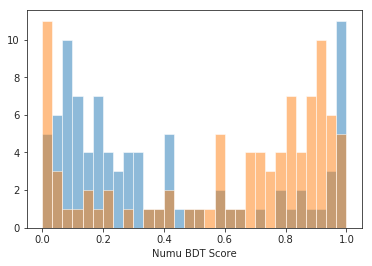

In [72]:
#nubkgscore_nue = nubkgBDT.predict(X,output_margin=True)
#nubkgscore_numu = nubkgBDT.predict(Y_numu,output_margin=True)
nubkgscore_nue = nubkgBDT.predict_proba(X)
#nubkgscore_numu = nubkgBDT.predict_proba(Y_numu)


fig,ax = plt.subplots(figsize=(6,4))
_ = plt.hist(nubkgscore_nue[:,0],30,(0,1),alpha = .5,label='nue')
_ = plt.hist(nubkgscore_nue[:,1],30,(0,1),alpha = .5,label='nue')
ax.set_xlabel('Numu BDT Score')


Text(0.5,0,'Cosmic BDT Score')

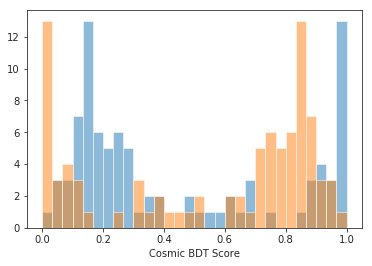

In [73]:
#nubkgscore_nue = nubkgBDT.predict(X,output_margin=True)
#nubkgscore_numu = nubkgBDT.predict(Y_numu,output_margin=True)
cosbkgscore_nue = cosmicBDT.predict_proba(X)
#nubkgscore_numu = nubkgBDT.predict_proba(Y_numu)


fig,ax = plt.subplots(figsize=(6,4))
_ = plt.hist(cosbkgscore_nue[:,0],30,(0,1),alpha = .5,label='nue')
_ = plt.hist(cosbkgscore_nue[:,1],30,(0,1),alpha = .5,label='nue')
ax.set_xlabel('Cosmic BDT Score')
#plt.legend(fontsize=18)

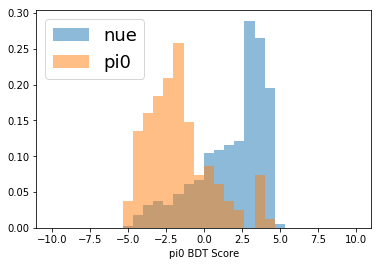

In [34]:
pi0score_nue = pi0BDT.predict(X,output_margin=True)
pi0score_pi0 = pi0BDT.predict(Y_pi0,output_margin=True)

fig,ax = plt.subplots(figsize=(6,4))
_ = plt.hist(pi0score_nue,30,(-10,10),alpha = .5,density=1,label='nue')
_ = plt.hist(pi0score_pi0,30,(-10,10),alpha = .5,density=1,label='pi0')
ax.set_xlabel('pi0 BDT Score')
plt.legend(fontsize=18)

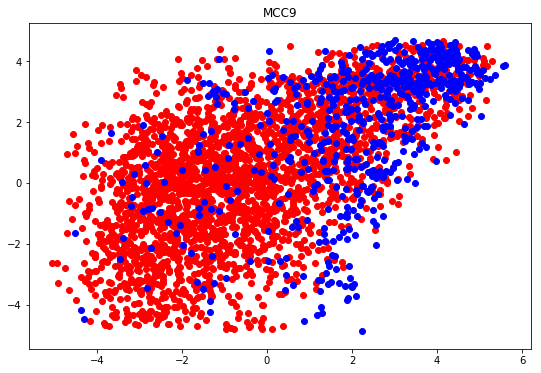

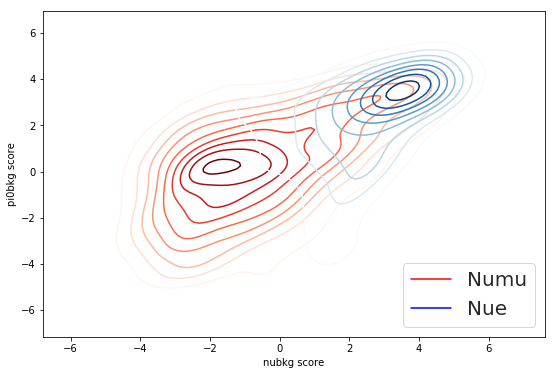

In [35]:
pi0bkg_nue = pi0BDT.predict(X,output_margin=True)
nubkg_nue = nubkgBDT.predict(X,output_margin=True)
pi0bkg_numu = pi0BDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True)
nubkg_numu = nubkgBDT.predict(df_numu_presel[myvars].values.tolist(),output_margin=True)

fig,ax = plt.subplots(figsize=(9,6))
ax.set_title('MCC9')
plt.scatter(nubkg_numu,pi0bkg_numu,color='red',label='Numu')
plt.scatter(nubkg_nue,pi0bkg_nue,color='blue',label='Nue')

fig,ax = plt.subplots(figsize=(9,6))
sns.set_style('ticks')
sns.kdeplot(nubkg_numu,pi0bkg_numu,label='Numu',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(nubkg_nue,pi0bkg_nue,label='Nue',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)

ax.set_xlabel('nubkg score')
ax.set_ylabel('pi0bkg score')
plt.legend(fontsize=20,loc='lower right')


In [39]:
bdts = [cosmicBDT,pi0BDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweight_1e1p_vNov6_fullrange.pickle", "wb" ))

In [43]:
bdts = [cosmicBDT,nubkgBDT]
pickle.dump(bdts,open( "../1mu1pSelection/bdtweight_1e1p_vOct31_twobdts.pickle", "wb" ))